Business Context -
================

This case requires trainees to develop a model for predicting fraudulent transactions for a 

financial company and use insights from the model to develop an actionable plan. Data for the 

case is available in CSV format having 6362620 rows and 10 columns.

Candidates can use whatever method they wish to develop their machine learning model. 

Following usual model development procedures, the model would be estimated on the 

calibration data and tested on the validation data. This case requires both statistical analysis and 

creativity/judgment. We recommend you spend time on both fine-tuning and interpreting the 

results of your machine learning model. 
    
Your task is to execute the process for proactive detection of fraud while answering following 

questions.

1. Data cleaning including missing values, outliers and multi-collinearity. 

2. Describe your fraud detection model in elaboration. 

3. How did you select variables to be included in the model?

4. Demonstrate the performance of the model by using best set of tools. 

5. What are the key factors that predict fraudulent customer? 

6. Do these factors make sense? If yes, How? If not, How not? 

7. What kind of prevention should be adopted while company update its infrastructure?

8. Assuming these actions have been implemented, how would you determine if they work?  

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
try:
    data = pd.read_csv('Downloads/Fraud.csv') 
except FileNotFoundError:
    print("Error: File not found. Please make sure the file path is correct.")
    exit()

In [52]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [54]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [55]:
legit = len(data[data.isFraud == 0])
fraud = len(data[data.isFraud == 1])
legit_percent = (legit / (fraud + legit)) * 100
fraud_percent = (fraud / (fraud + legit)) * 100

print("Number of Legit transactions: ", legit)
print("Number of Fraud transactions: ", fraud)
print("Percentage of Legit transactions: {:.4f} %".format(legit_percent))
print("Percentage of Fraud transactions: {:.4f} %".format(fraud_percent))

Number of Legit transactions:  6354407
Number of Fraud transactions:  8213
Percentage of Legit transactions: 99.8709 %
Percentage of Fraud transactions: 0.1291 %


In [56]:
print(f"\nNumber of duplicate rows: {data.duplicated().sum()}")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000019DB8D82DB0>>
Traceback (most recent call last):
  File "C:\Users\Pranjal Kashyap\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Pranjal Kashyap\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1533, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
x = data[data['nameDest'].str.contains('M')]
x.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


For merchants there is no information regarding the attribites oldbalanceDest and newbalanceDest.

--- Outlier Detection and Handling ---

In [ ]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

In [ ]:
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
outlier_results = {}

for col in numerical_cols:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(data, col)
    outlier_results[col] = {
        'outliers': outliers,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
    }
    print(f"\nOutliers in column '{col}': {len(outliers)}")


Outliers in column 'amount': 338078

Outliers in column 'oldbalanceOrg': 1112507

Outliers in column 'newbalanceOrig': 1053391

Outliers in column 'oldbalanceDest': 786135

Outliers in column 'newbalanceDest': 738527


In [ ]:
for col in numerical_cols:
    if col in outlier_results: 
        lower_bound = outlier_results[col]['lower_bound']
        upper_bound = outlier_results[col]['upper_bound']
        data[col] = np.clip(data[col], lower_bound, upper_bound)
        print(f"Outliers in column '{col}' capped to [{lower_bound}, {upper_bound}]")

Outliers in column 'amount' capped to [-279608.29125, 501719.33875]
Outliers in column 'oldbalanceOrg' capped to [-160972.7625, 268287.9375]
Outliers in column 'newbalanceOrig' capped to [-216387.615, 360646.025]
Outliers in column 'oldbalanceDest' capped to [-1414555.06125, 2357591.76875]
Outliers in column 'newbalanceDest' capped to [-1667863.875, 2779773.125]


In [ ]:
correlation_matrix = data[numerical_cols].corr()

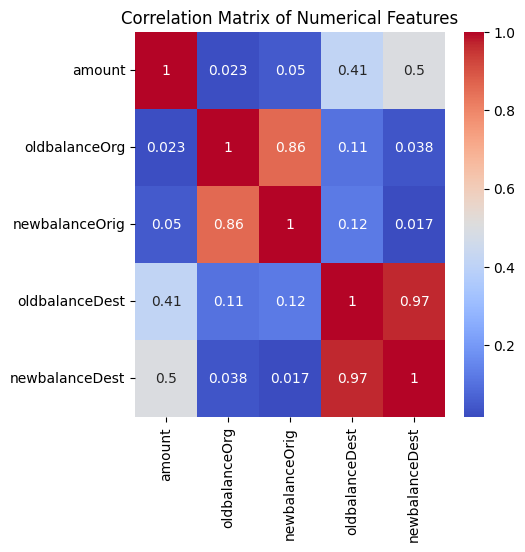

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

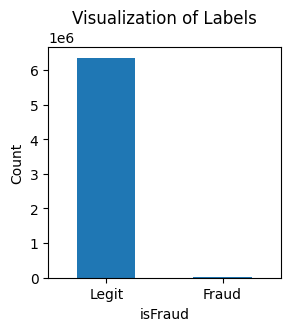

In [ ]:
plt.figure(figsize=(3,3))
labels = ["Legit", "Fraud"]
count_classes = data.value_counts(data['isFraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

In [ ]:
data1 = data.copy()
data1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Label Encoding

In [ ]:
objList = data1.select_dtypes(include = "object").columns
print (objList)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


THERE ARE 3 ATTRIBUTES WITH Object Datatype. THUS WE NEED TO LABEL ENCODE THEM IN ORDER TO CHECK MULTICOLINEARITY.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    data1[feat] = le.fit_transform(data1[feat].astype(str))

print (data1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(6)
memory usage: 534.0 MB
None


In [ ]:
data1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


MULTICOLINEARITY

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [ ]:
def calculate_vif(data):

    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return(vif)

calculate_vif(data1)

,variables,VIF
0,step,3.074162
1,type,5.340388
2,amount,3.017503
3,nameOrig,3.112559
4,oldbalanceOrg,6.290525
5,newbalanceOrig,7.313279
6,nameDest,4.198199
7,oldbalanceDest,34.207066
8,newbalanceDest,38.183047
9,isFraud,1.025404


In [ ]:
data1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


We can see that oldbalanceOrg and newbalanceOrig have too high VIF thus they are highly correlated. Similarly oldbalanceDest and newbalanceDest. Also nameDest is connected to nameOrig.

Thus combine these pairs of collinear attributes and drop the individual ones.

In [ ]:
data1['Actual_amount_orig'] = data1.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
data1['Actual_amount_dest'] = data1.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
data1['TransactionPath'] = data1.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

data1 = data1.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calculate_vif(data1)

,variables,VIF
0,type,2.859519
1,amount,2.323191
2,isFraud,1.018565
3,isFlaggedFraud,1.002008
4,Actual_amount_orig,1.431167
5,Actual_amount_dest,1.983253
6,TransactionPath,3.028186


<Axes: >

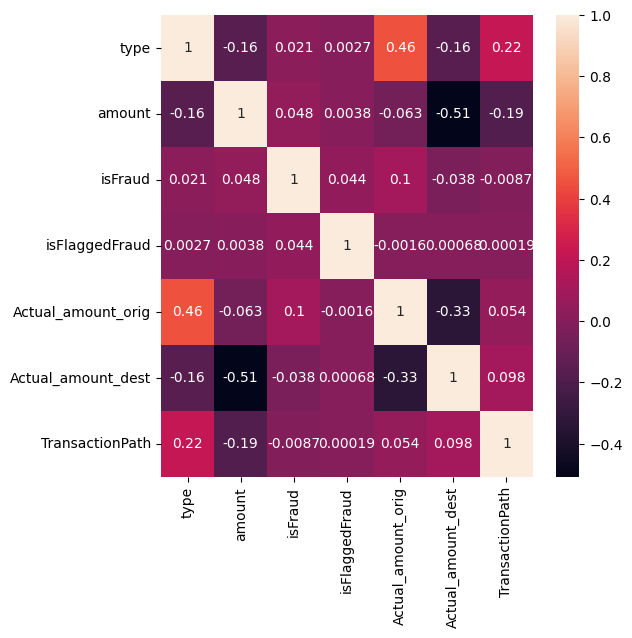

In [ ]:
corr=data1.corr()

plt.figure(figsize=(6,6))
sns.heatmap(corr,annot=True)

Using the VIF values and correlation heatmap. We just need to check if there are any two attributes highly correlated to each other and then drop the one which is less correlated to the is a Fraud Attribute.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
data1["NormalizedAmount"] = scaler.fit_transform(data1["amount"].values.reshape(-1, 1))
data1.drop(["amount"], inplace= True, axis= 1)

x = data1.drop(["isFraud"], axis= 1)
y = data1["isFraud"] 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((5090096, 6), (1272524, 6))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

pred_dt = decision_tree.predict(x_test)
decision_tree_score = decision_tree.score(x_test, y_test) * 100

In [ ]:
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(x_train, y_train)

pred_rf = random_forest.predict(x_test)
random_forest_score = random_forest.score(x_test, y_test) * 100

In [ ]:
print("Decision Tree Score: ", decision_tree_score)
print("Random Forest Score: ", random_forest_score)

Decision Tree Score:  99.91340045452974
Random Forest Score:  99.94970625308443


In [ ]:
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

TP(Decision Tree) ~ TP(Random Forest) so no competetion here.
FP(Decision Tree) >> FP(Random Forest) - Random Forest has an edge
TN(Decision Tree) < TN(Random Forest) - Random Forest is better here too
FN(Decision Tree) ~ FN(Random Forest)

In [ ]:
print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(y_test, pred_dt).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("----------------------------------------------------------------------------------------")

print("TP,FP,TN,FN - Random Forest")
tn, fp, fn, tp = confusion_matrix(y_test, pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 1104
False Positives: 586
True Negatives: 1270318
False Negatives: 516
----------------------------------------------------------------------------------------
TP,FP,TN,FN - Random Forest
True Positives: 1099
False Positives: 119
True Negatives: 1270785
False Negatives: 521



TP(Decision Tree) ~ TP(Random Forest) so no competetion here.
FP(Decision Tree) >> FP(Random Forest) - Random Forest has an edge
TN(Decision Tree) < TN(Random Forest) - Random Forest is better here too
FN(Decision Tree) ~ FN(Random Forest)


Here Random Forest looks good.

In [ ]:
confusion_matrix_dt = confusion_matrix(y_test, pred_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt,)

print("----------------------------------------------------------------------------------------")

confusion_matrix_rf = confusion_matrix(y_test, pred_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf) 

Confusion Matrix - Decision Tree
[[1270318     586]
 [    516    1104]]
----------------------------------------------------------------------------------------
Confusion Matrix - Random Forest
[[1270785     119]
 [    521    1099]]


In [ ]:
classification_report_dt = classification_report(y_test, pred_dt)
print("Classification Report - Decision Tree")
print(classification_report_dt)

print("----------------------------------------------------------------------------------------")


classification_report_rf = classification_report(y_test, pred_rf)
print("Classification Report - Random Forest")
print(classification_report_rf) 

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.65      0.68      0.67      1620

    accuracy                           1.00   1272524
   macro avg       0.83      0.84      0.83   1272524
weighted avg       1.00      1.00      1.00   1272524

----------------------------------------------------------------------------------------
Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.90      0.68      0.77      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.84      0.89   1272524
weighted avg       1.00      1.00      1.00   1272524



With Such a good precision and hence F1-Score, Random Forest comes out to be better as expected.

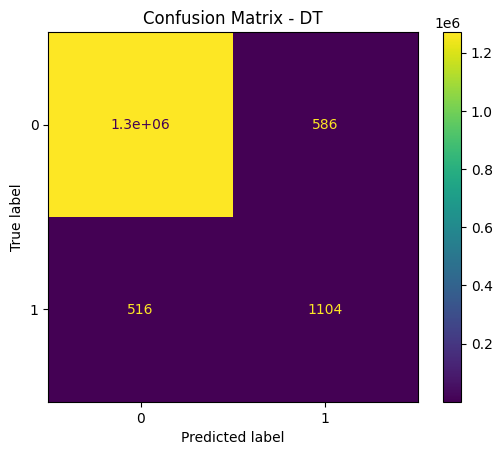

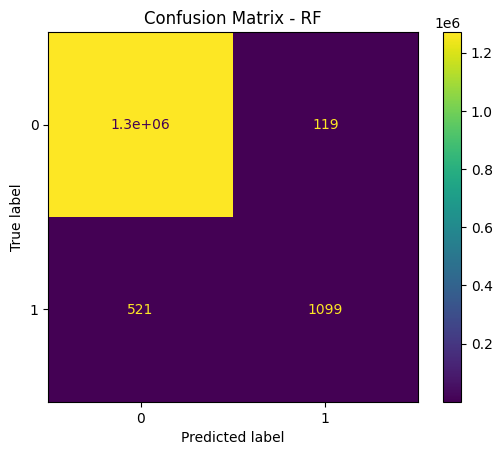

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp.plot()
plt.title('Confusion Matrix - DT')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show() 

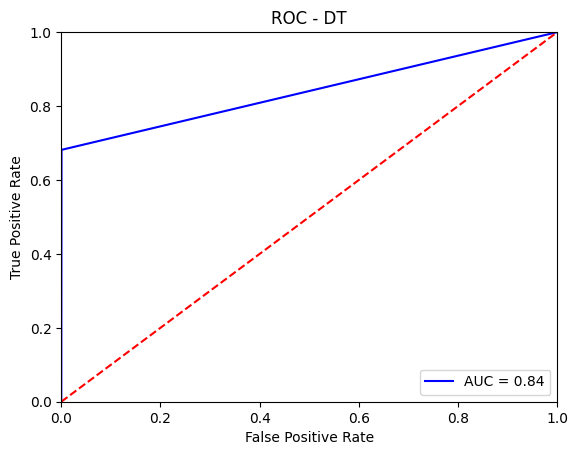

In [58]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

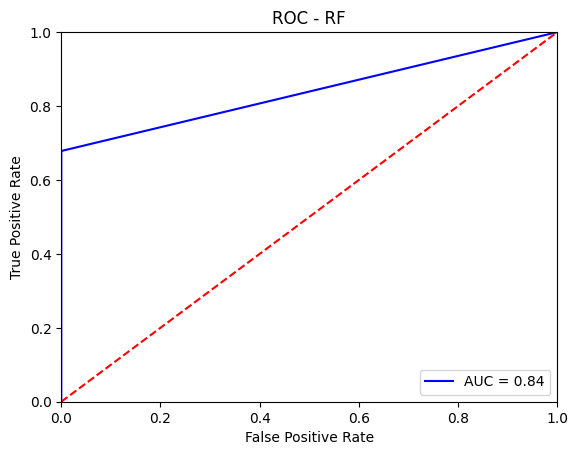

In [59]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

THE AUC for both Decision Tree and Random Forest is equal, so both models are pretty good at what they do.

Conclusion - 

We have seen that Accuracy of both Random Forest and Decision Tree is equal, although teh precision of Random Forest is more. In a fraud detection model, Precision is highly important because rather than predicting normal transactions correctly we want Fraud transactions to be predicted correctly and Legit to be left off.If either of the 2 reasons are not fulfiiled we may catch the innocent and leave the culprit.
This is also one of the reason why Random Forest and Decision Tree are used unstead of other algorithms.


Also the reason I have chosen this model is because of highly unbalanced dataset (Legit: Fraud :: 99.87:0.13). Random forest makes multiple decision trees which makes it easier (although time taking) for model to understand the data in a simpler way since Decision Tree makes decisions in a boolean way.


Models like XGBoost, Bagging, ANN, and Logistic Regression may give good accuracy but they won't give good precision and recall values.

What are the key factors that predict fraudulent customer?

1. The source of request is secured or not ?
2. Is the name of organisation asking for money is legit or not ?
3. Transaction history of vendors.

They make sense because:

1. Source security is key in identifying potential unauthorized access or data breaches.

2. Organization legitimacy helps confirm that the entity asking for money is who it claims to be.

3. Transaction history can reveal red flags such as vendors with abnormal activities, which could indicate fraudulent behavior.

What kind of prevention should be adopted while company update its infrastructure?

1. Use smart vertified apps only.
2. Browse through secured websites.
3. Use secured internet connections (USE VPN).
4. Keep your mobile and laptop security updated.
5. Don't respond to unsolicited calls/SMS.
6. If you feel like you have been tricked or security compromised, contact your bank immidiately.

Assuming these actions have been implemented, how would you determine if they work?

1. Bank sending E-statements.
2. Customers keeping a check of their account activity.
3. Always keep a log of your payments.